In [ ]:
#Some libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

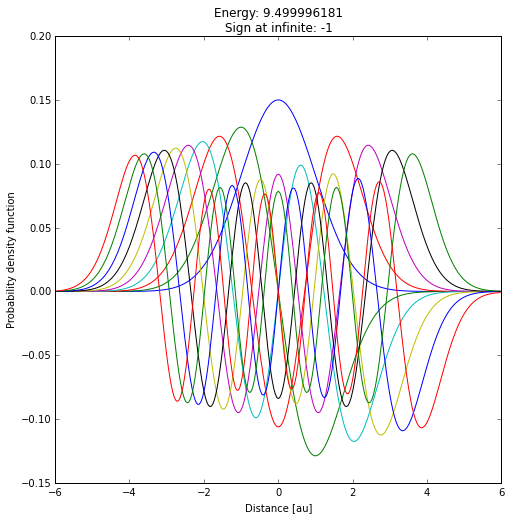

In [10]:
#Using the Numerov method for solving the Schrodinger equation for the harmonic potential

#Since this is an eigen values problem, we not only have to solve the differential equation, but find the solutions that
#satisfy boundary conditions, which in this case is f[-inf]=0, f[+inf]=0. This will only occur for certain energies.
#This method is really inefficient in python, becuase it is purely iterative, and for efficiency should be implemented
#in a lower level programming language for any serious calculations.

#Potential
def K(x,E):
    return 2*E-x**2
    
    
N=300 #Number of iterations for Numerov


E=0 #Starting energy
E_step=0.1 #Minimum energy step, we will assume that there are not two eigen values for the energy separated by less than 0.1
E_step_sign=1


h=0.04
h2=h**2;
b=h2/12;
a=0.1;
precision=10 #Precision to which we want to obtain the eigen values, calculated as 10**(-precision)


eigenfunctions=[]
eigenvalues=[]

lastsign=0; #

nextVal=False

fig=plt.figure(figsize=(8, 8)) # supoose I know what the limits are going to be
ax=fig.add_subplot('111')
line,=ax.plot([0],[0])
plt.ion()
plt.xlabel('Distance [au]')
plt.ylabel('Probability density function')
plt.show()


exit=False #Flag to leave the loop
while (not exit):
    
    #We solve Numerov for the energy E
    x=np.zeros(N,dtype=np.float64)
    y=np.zeros(N,dtype=np.float64)    
    k=np.zeros(N,dtype=np.float64) 
    
    i=0
    y[i]=0   #Manually add the condition f[-inf]=0, at the lowest negative distance
    x[i]=-N/2*h
    k[i]=K(x[i],E)
    
    y[i+1]=a
    x[i+1]=x[i]+h
    k[i+1]=K(x[i+1],E)
    i+=1    
    while(i<N-1):
        x[i+1]=x[i]+h
        k[i+1]=K(x[i+1],E)
        y[i+1]=(2*(1-5*b*k[i])*y[i]-(1+b*k[i-1])*y[i-1])/(1+b*k[i+1])    
        i+=1
    line.set_data(x,y/np.sqrt((np.abs(y)**2).sum()))
    ax.relim()
    ax.autoscale_view()
    ax.set_title('Energy: %.10g \nSign at infinite: %g'%(E,lastsign))
    
    display.clear_output(wait=True)
    display.display(fig) 
        
    
    #We check the sign at the last point to check that f[-inf]=0,
    #If the value were exactly 0, we woudl have found an eigenvalue, howevere, this never happens
    #If this is the first time we check the sign in the search of this eigen value, we have to keep increasin the same direction
    #If the sign between the previous search and this search has changed, then we have surrounded the solution, we just need to narrow the interval
    # and for this we use a binomial approach, where we divide the step by a factor of 2.
    
    sign=y[-1]/abs(y[-1])
    if(lastsign == 0):
        lastsign=sign
    elif(sign!=lastsign):
        lastsign=sign
        E_step_sign=E_step_sign*-1
        E_step=E_step/2       
        
        if E_step<10**(-precision): #If the step is smaller than the precision, our solution is good enough, and we start searching for the next one
            nextVal=True
    
    #If the distance from 0 of the last point step is smaller than the precision, our solution is also enough, and we start searching for the next one
    if abs(y[-1])<10*a:
        nextVal=True
        
    #We store the current results, reset the variables, and look for the next solution.    
    if nextVal:
        eigenvalues.append(E)
        eigenfunctions.append(y/np.sqrt((np.abs(y)**2).sum()))
        E_step=0.1
        E_step_sign=1
        lastsign=0
        line,=ax.plot([0],[0])
        nextVal=False
        
        if len(eigenfunctions)>=10: #After 10 solutions we stop
            exit=True
    E+=E_step_sign*E_step

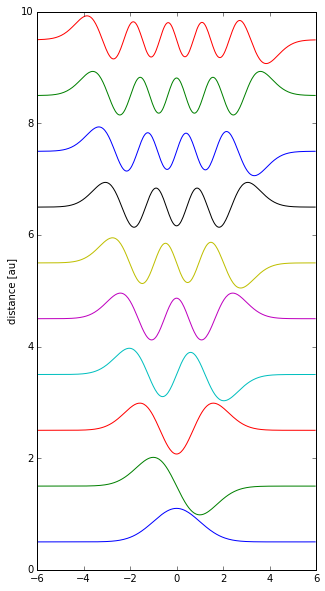

In [15]:
#Plotting the eigen states at the given energies
#As expected the eigen states follow 1/2+n with n=0,1,2,3,4,...

import matplotlib.pyplot as plt

scaling=4

plt.figure(figsize=(5,10))
plt.ylabel('Energies [au]')
plt.ylabel('distance [au]')
for energy,solution in zip(eigenvalues,eigenfunctions):
    plt.plot(x,solution*scaling+energy)
    

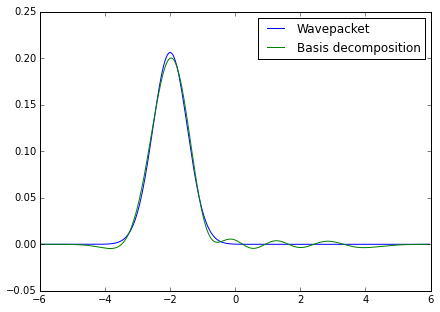

In [31]:

#Now we are going to see how a wavepacket propagate. For this we express our initial wavepacket as a linear combination of our eigen functions.

wavepacket=np.exp(-(x-(-2))**2/(0.75)**2) 
wavepacket=wavepacket/np.sqrt((abs(wavepacket)**2).sum()) #Normalized initial wavepacket
plt.figure(figsize=(7,5))
plt.plot(x,wavepacket,label='Wavepacket')

#We set the coefficients to be the inner product of each of the states with our wavepacket, normalizing at the end
coefficients=np.zeros(len(eigenfunctions))
for i in range(len(eigenfunctions)):
    coefficients[i]=(wavepacket*eigenfunctions[i]).sum()
coefficients=coefficients/(coefficients**2).sum()
    
#We reconstruct our wavepacket from functions in the basis
wavepacketsuper=np.zeros(len(wavepacket))
for i in range(len(coefficients)):
    wavepacketsuper+=(coefficients[i]*eigenfunctions[i])
plt.plot(x,wavepacketsuper,label='Basis decomposition')
plt.legend()

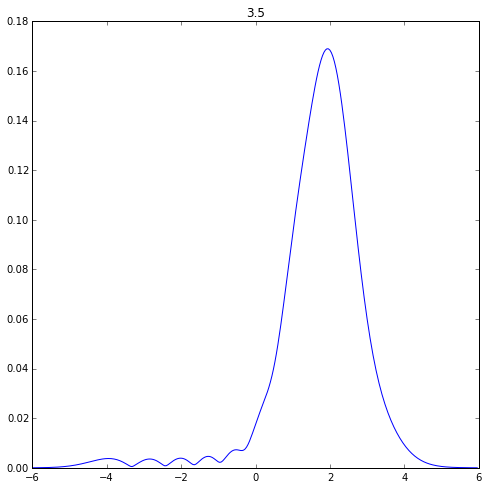

In [35]:
#Now that we have out wavepacket decomposed on eigenfunctions, we can propagate in time, and we can see it reflecting left and right!

fig=plt.figure(figsize=(8, 8)) 
ax=fig.add_subplot('111')
line,=ax.plot([0],[0])
plt.ion()
plt.show()

exit=False
t=0
#Try except, to catch the stop kernel exception
try:
    while (not exit):
        wavepacketsuper=np.zeros(len(wavepacket),dtype=np.complex128)
        for i in range(len(coefficients)):
            wavepacketsuper+=(coefficients[i]*eigenfunctions[i])*np.exp(1j*t*(i+0.5))
        line.set_data(x,np.abs(wavepacketsuper))
        ax.relim()
        ax.autoscale_view()
        ax.set_title('%.10g'%(t))

        display.clear_output(wait=True)
        display.display(fig) 
        t=t+0.25
except:
    pass

    
